In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns

In [2]:
#loading ndvi, ndbi and bu(built-up)
built_up = pd.read_csv('NDBI_NDVI_BUILT_new.csv')
built_up.head()

,NDBI,NDVI,BU,longitude,latitude
0,-0.093054,0.097206,-0.204207,9.057309,45.378441
1,-0.082932,0.133158,-0.213055,9.057578,45.378441
2,-0.059312,0.117617,-0.187786,9.057848,45.378441
3,-0.059312,0.117617,-0.187786,9.058117,45.378441
4,-0.026199,0.096020,-0.149954,9.058387,45.378441


In [3]:
built_up.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631928 entries, 0 to 631927
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   NDBI       631928 non-null  float64
 1   NDVI       631928 non-null  float64
 2   BU         631928 non-null  float64
 3   longitude  631928 non-null  float64
 4   latitude   631928 non-null  float64
dtypes: float64(5)
memory usage: 24.1 MB


In [4]:
ndwi_index = pd.read_csv('NDWI.csv')
ndwi_index.head()

,system:index,NDWI,.geo
0,0,-0.102130,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,1,-0.102130,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,2,-0.098537,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,3,-0.097505,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,4,-0.095059,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


extracting longitude and latitude from .geocolumn

In [5]:
# Function to extract coordinates
def extract_coordinates(point):
    point_dict = json.loads(point)
    longitude = point_dict['coordinates'][0]
    latitude = point_dict['coordinates'][1]
    return longitude, latitude



In [6]:
# Apply the function to the 'point' column
ndwi_index[['longitude', 'latitude']] = ndwi_index['.geo'].apply(lambda x: pd.Series(extract_coordinates(x)))


ndwi_index.head()

,system:index,NDWI,.geo,longitude,latitude
0,0,-0.102130,"{""geodesic"":false,""type"":""Point"",""coordinates""...",9.058656,45.391377
1,1,-0.102130,"{""geodesic"":false,""type"":""Point"",""coordinates""...",9.058926,45.391377
2,2,-0.098537,"{""geodesic"":false,""type"":""Point"",""coordinates""...",9.059195,45.391377
3,3,-0.097505,"{""geodesic"":false,""type"":""Point"",""coordinates""...",9.059465,45.391377
4,4,-0.095059,"{""geodesic"":false,""type"":""Point"",""coordinates""...",9.059734,45.391377


In [7]:
ndwi = ndwi_index[['longitude', 'latitude', 'NDWI']]
ndwi.head()

,longitude,latitude,NDWI
0,9.058656,45.391377,-0.102130
1,9.058926,45.391377,-0.102130
2,9.059195,45.391377,-0.098537
3,9.059465,45.391377,-0.097505
4,9.059734,45.391377,-0.095059


In [8]:
ndwi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630982 entries, 0 to 630981
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   longitude  630982 non-null  float64
 1   latitude   630982 non-null  float64
 2   NDWI       630982 non-null  float64
dtypes: float64(3)
memory usage: 14.4 MB


In [33]:
# Convert pandas dataframes to geopandas geodataframes and perform a spatial join.
def convert_and_join(df1, df2, max_distance=0.01):
    # Convert pandas dataframes to geopandas geodataframes
    gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.longitude, df1.latitude))
    gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude, df2.latitude))

    # Perform the spatial join
    merged_gdf = gpd.sjoin_nearest(gdf1, gdf2, how='inner', max_distance=max_distance)

    # Drop specific columns and convert back to pandas DataFrame
    merged_gdf = pd.DataFrame(merged_gdf.drop(columns=['geometry', 'index_right', 'longitude_right', 'latitude_right']))

    return merged_gdf

Joining the vegetation and water index using the convert_and_join function

In [12]:
vegetation = convert_and_join(built_up, ndwi)
vegetation.head()

,NDBI,NDVI,BU,longitude_left,latitude_left,NDWI
10409,-0.105596,0.126532,-0.222181,9.058117,45.381406,-0.102130
10410,-0.095556,0.123296,-0.204842,9.058387,45.381406,-0.102130
10411,-0.102717,0.126751,-0.214675,9.058656,45.381406,-0.102130
10412,-0.102717,0.126751,-0.214675,9.058926,45.381406,-0.102130
10413,-0.106370,0.138298,-0.236660,9.059195,45.381406,-0.098537


Removing unwanted columns

In [13]:
vegetation.rename(columns = {'longitude_left':'longitude', 'latitude_left':'latitude'}, inplace = True)
vegetation=vegetation[['longitude', 'latitude', 'NDVI', 'NDBI', 'BU', 'NDWI']]
vegetation.head()

,longitude,latitude,NDVI,NDBI,BU,NDWI
10409,9.058117,45.381406,0.126532,-0.105596,-0.222181,-0.102130
10410,9.058387,45.381406,0.123296,-0.095556,-0.204842,-0.102130
10411,9.058656,45.381406,0.126751,-0.102717,-0.214675,-0.102130
10412,9.058926,45.381406,0.126751,-0.102717,-0.214675,-0.102130
10413,9.059195,45.381406,0.138298,-0.106370,-0.236660,-0.098537


In [14]:
# checking the stastical values of vegetation data
vegetation.describe()

,longitude,latitude,NDVI,NDBI,BU,NDWI
count,621519.000000,621519.000000,621519.000000,621519.000000,621519.000000,621519.000000
mean,9.184646,45.469801,0.110097,-0.077601,-0.198264,-0.106194
std,0.073595,0.051112,0.058350,0.051080,0.090456,0.050982
min,9.057309,45.381406,-0.056044,-0.257022,-0.609012,-0.347099
25%,9.120909,45.425603,0.064243,-0.117480,-0.251980,-0.133889
50%,9.184780,45.469800,0.099556,-0.081115,-0.198483,-0.096892
75%,9.248380,45.513997,0.143404,-0.040011,-0.140243,-0.070699
max,9.311981,45.558194,0.393242,0.204732,0.161062,0.118675


In [15]:
#checking for null values
vegetation.isnull().sum()

longitude    0
latitude     0
NDVI         0
NDBI         0
BU           0
NDWI         0
dtype: int64

In [21]:
#loading the sunlight data
sunlight =pd.read_csv('Solar_Exposure_Zone9.csv')
sunlight.head()

,latitude,longitude,Zone,GHI (kWh/m2)
0,45.498270,9.167314,Zone 9,1405.9
1,45.525914,9.193439,Zone 9,1404.5
2,45.504756,9.169082,Zone 9,1405.5
3,45.497957,9.191830,Zone 9,1405.7
4,45.497326,9.179873,Zone 9,1405.7


Checking the Sunlight details

In [22]:
sunlight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1772 entries, 0 to 1771
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      1772 non-null   float64
 1   longitude     1772 non-null   float64
 2   Zone          1772 non-null   object 
 3   GHI (kWh/m2)  1772 non-null   float64
dtypes: float64(3), object(1)
memory usage: 55.5+ KB


In [23]:
sunlight.describe()

,latitude,longitude,GHI (kWh/m2)
count,1772.000000,1772.000000,1772.000000
mean,45.502019,9.187006,1405.573420
std,0.014505,0.013994,0.828344
min,45.480228,9.148030,1404.200000
25%,45.487905,9.178067,1404.800000
50%,45.501713,9.187327,1405.600000
75%,45.514711,9.194655,1406.200000
max,45.533753,9.216759,1407.400000


Joining the  Sunlight to Vegetation

In [37]:
veg_sun =convert_and_join(vegetation, sunlight)
veg_sun.head()

,longitude_left,latitude_left,NDVI,NDBI,BU,NDWI,Zone,GHI (kWh/m2)
323086,9.192056,45.470339,0.035252,-0.021838,-0.107042,-0.045314,Zone 9,1407.4
323087,9.192326,45.470339,0.045778,-0.053561,-0.148905,-0.044262,Zone 9,1407.4
323088,9.192595,45.470339,0.045778,-0.053561,-0.148905,-0.044262,Zone 9,1407.4
323089,9.192865,45.470339,0.029497,-0.010491,-0.053904,-0.037226,Zone 9,1407.4
323090,9.193134,45.470339,0.029267,-0.002303,-0.033748,-0.029045,Zone 9,1407.4


In [38]:
veg_sun.rename(columns=({'longitude_left': 'longitude', 'latitude_left': 'latitude'}), inplace= True)

In [39]:
veg_sun.describe()

,longitude,latitude,NDVI,NDBI,BU,NDWI,GHI (kWh/m2)
count,60015.000000,60015.000000,60015.000000,60015.000000,60015.000000,60015.000000,60015.000000
mean,9.182693,45.510588,0.084588,-0.060524,-0.164363,-0.084388,1405.305172
std,0.021299,0.017357,0.048919,0.051697,0.082254,0.039858,0.795857
min,9.138157,45.470339,-0.009185,-0.206260,-0.529114,-0.305451,1404.200000
25%,9.165915,45.497828,0.050283,-0.100275,-0.212513,-0.098587,1404.600000
50%,9.183163,45.512111,0.069346,-0.055870,-0.173746,-0.073786,1405.100000
75%,9.199602,45.524777,0.106201,-0.022348,-0.099250,-0.058868,1405.900000
max,9.226551,45.543642,0.338587,0.169801,0.132600,0.079937,1407.400000


Loading and joining the Soil and Climate date to Vegetation and Sun

In [48]:
#loading Soil and climate data
soil_climate = pd.read_csv('climate_soil.csv', index_col=0)
soil_climate

,longitude,latitude,Air_temperature,precipitation,Soil_temperature,Soil_moisture
0,9.219662,45.488191,288.107819,0.00004,281.803619,35.170303
1,9.263653,45.533019,287.939575,0.00004,281.016296,34.989101
2,9.303852,45.478387,287.874054,0.00004,281.004852,34.630409
3,9.205276,45.536104,287.874054,0.00004,281.004852,34.630409
4,9.169540,45.399016,287.874054,0.00004,281.004852,34.630409
...,...,...,...,...,...,...
995,9.235556,45.472416,287.874054,0.00004,281.004852,34.630409
996,9.218177,45.481735,288.107819,0.00004,281.803619,35.170303
997,9.125311,45.526378,287.874054,0.00004,281.004852,34.630409
998,9.161494,45.461840,287.874054,0.00004,281.004852,34.630409


In [49]:
soil_climate.describe()

,longitude,latitude,Air_temperature,precipitation,Soil_temperature,Soil_moisture
count,1000.000000,1000.000000,995.000000,9.950000e+02,995.000000,995.000000
mean,9.190984,45.459627,287.895551,3.965596e-05,281.073081,34.710675
std,0.064005,0.044264,0.113185,6.629272e-08,0.382057,0.238245
min,9.063362,45.371271,287.735657,3.958410e-05,280.547882,34.447247
25%,9.137695,45.423472,287.874054,3.963647e-05,281.004852,34.630409
50%,9.190129,45.462807,287.874054,3.963647e-05,281.004852,34.630409
75%,9.242607,45.494767,287.874054,3.963647e-05,281.004852,34.630409
max,9.316089,45.547806,288.107819,3.984100e-05,281.803619,35.170303


In [50]:
#joining  Vegetation_sun data and soil_climate data
vegsun_climatesoil = convert_and_join(veg_sun, soil_climate)
vegsun_climatesoil.head()

,longitude_left,latitude_left,NDVI,NDBI,BU,NDWI,Zone,GHI (kWh/m2),Air_temperature,precipitation,Soil_temperature,Soil_moisture
323086,9.192056,45.470339,0.035252,-0.021838,-0.107042,-0.045314,Zone 9,1407.4,287.874054,0.00004,281.004852,34.630409
323087,9.192326,45.470339,0.045778,-0.053561,-0.148905,-0.044262,Zone 9,1407.4,287.874054,0.00004,281.004852,34.630409
323088,9.192595,45.470339,0.045778,-0.053561,-0.148905,-0.044262,Zone 9,1407.4,287.874054,0.00004,281.004852,34.630409
323089,9.192865,45.470339,0.029497,-0.010491,-0.053904,-0.037226,Zone 9,1407.4,287.874054,0.00004,281.004852,34.630409
323090,9.193134,45.470339,0.029267,-0.002303,-0.033748,-0.029045,Zone 9,1407.4,287.874054,0.00004,281.004852,34.630409


In [56]:
vegsun_climatesoil.drop(columns=('Zone'), inplace= True)
vegsun_climatesoil.head()

,longitude,latitude,NDVI,NDBI,BU,NDWI,GHI (kWh/m2),Air_temperature,precipitation,Soil_temperature,Soil_moisture,class
323086,9.192056,45.470339,0.035252,-0.021838,-0.107042,-0.045314,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
323087,9.192326,45.470339,0.045778,-0.053561,-0.148905,-0.044262,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
323088,9.192595,45.470339,0.045778,-0.053561,-0.148905,-0.044262,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
323089,9.192865,45.470339,0.029497,-0.010491,-0.053904,-0.037226,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
323090,9.193134,45.470339,0.029267,-0.002303,-0.033748,-0.029045,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas


In [57]:
vegsun_climatesoil.rename(columns=({'longitude_left': 'longitude', 'latitude_left': 'latitude','GHI (kWh/m2)':'Solar(kWh/m2)' }), inplace= True)
vegsun_climatesoil

,longitude,latitude,NDVI,NDBI,BU,NDWI,Solar(kWh/m2),Air_temperature,precipitation,Soil_temperature,Soil_moisture,class
323086,9.192056,45.470339,0.035252,-0.021838,-0.107042,-0.045314,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
323087,9.192326,45.470339,0.045778,-0.053561,-0.148905,-0.044262,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
323088,9.192595,45.470339,0.045778,-0.053561,-0.148905,-0.044262,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
323089,9.192865,45.470339,0.029497,-0.010491,-0.053904,-0.037226,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
323090,9.193134,45.470339,0.029267,-0.002303,-0.033748,-0.029045,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
...,...,...,...,...,...,...,...,...,...,...,...,...
580327,9.172922,45.543642,0.110482,-0.092619,-0.207805,-0.096159,1404.7,287.735657,0.00004,280.547882,34.447247,Sparse Vegetation
580328,9.173191,45.543642,0.110482,-0.092619,-0.207805,-0.096159,1404.7,287.735657,0.00004,280.547882,34.447247,Sparse Vegetation
580329,9.173461,45.543642,0.104641,-0.083656,-0.214079,-0.099659,1404.7,287.735657,0.00004,280.547882,34.447247,Sparse Vegetation
580330,9.173730,45.543642,0.059343,0.002134,-0.081578,-0.067158,1404.7,287.735657,0.00004,280.547882,34.447247,Bare Soil/ Built-up Areas


In [52]:
vegsun_climatesoil.describe()

,longitude,latitude,NDVI,NDBI,BU,NDWI,GHI (kWh/m2),Air_temperature,precipitation,Soil_temperature,Soil_moisture
count,60015.000000,60015.000000,60015.000000,60015.000000,60015.000000,60015.000000,60015.000000,60015.000000,6.001500e+04,60015.000000,60015.000000
mean,9.182693,45.510588,0.084588,-0.060524,-0.164363,-0.084388,1405.305172,287.885450,3.967119e-05,281.037521,34.704401
std,0.021299,0.017357,0.048919,0.051697,0.082254,0.039858,0.795857,0.126727,7.650334e-08,0.425920,0.259649
min,9.138157,45.470339,-0.009185,-0.206260,-0.529114,-0.305451,1404.200000,287.735657,3.958410e-05,280.547882,34.447247
25%,9.165915,45.497828,0.050283,-0.100275,-0.212513,-0.098587,1404.600000,287.735657,3.963647e-05,280.547882,34.447247
50%,9.183163,45.512111,0.069346,-0.055870,-0.173746,-0.073786,1405.100000,287.874054,3.963647e-05,281.004852,34.630409
75%,9.199602,45.524777,0.106201,-0.022348,-0.099250,-0.058868,1405.900000,287.874054,3.976374e-05,281.004852,34.630409
max,9.226551,45.543642,0.338587,0.169801,0.132600,0.079937,1407.400000,288.107819,3.984100e-05,281.803619,35.170303


In [ ]:
# Define a function to classify vegetation based on NDVI value
def classify_vegetation(ndvi):
    if ndvi < 0.1:
        return 'Bare Soil/ Built-up Areas'
    elif 0.1 <= ndvi < 0.2:
        return 'Sparse Vegetation'
    elif 0.2 <= ndvi < 0.5:
        return 'Moderate Vegetation'
    elif ndvi >= 0.5:
        return 'Dense Vegetation'
    else:
        return 'null'



In [58]:
# Apply the classification function to the NDVI column and create a class column
vegsun_climatesoil['class'] = vegsun_climatesoil['NDVI'].apply(classify_vegetation)
vegsun_climatesoil.head()

,longitude,latitude,NDVI,NDBI,BU,NDWI,Solar(kWh/m2),Air_temperature,precipitation,Soil_temperature,Soil_moisture,class
323086,9.192056,45.470339,0.035252,-0.021838,-0.107042,-0.045314,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
323087,9.192326,45.470339,0.045778,-0.053561,-0.148905,-0.044262,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
323088,9.192595,45.470339,0.045778,-0.053561,-0.148905,-0.044262,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
323089,9.192865,45.470339,0.029497,-0.010491,-0.053904,-0.037226,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas
323090,9.193134,45.470339,0.029267,-0.002303,-0.033748,-0.029045,1407.4,287.874054,0.00004,281.004852,34.630409,Bare Soil/ Built-up Areas


Exploratory Analysis and visualisation

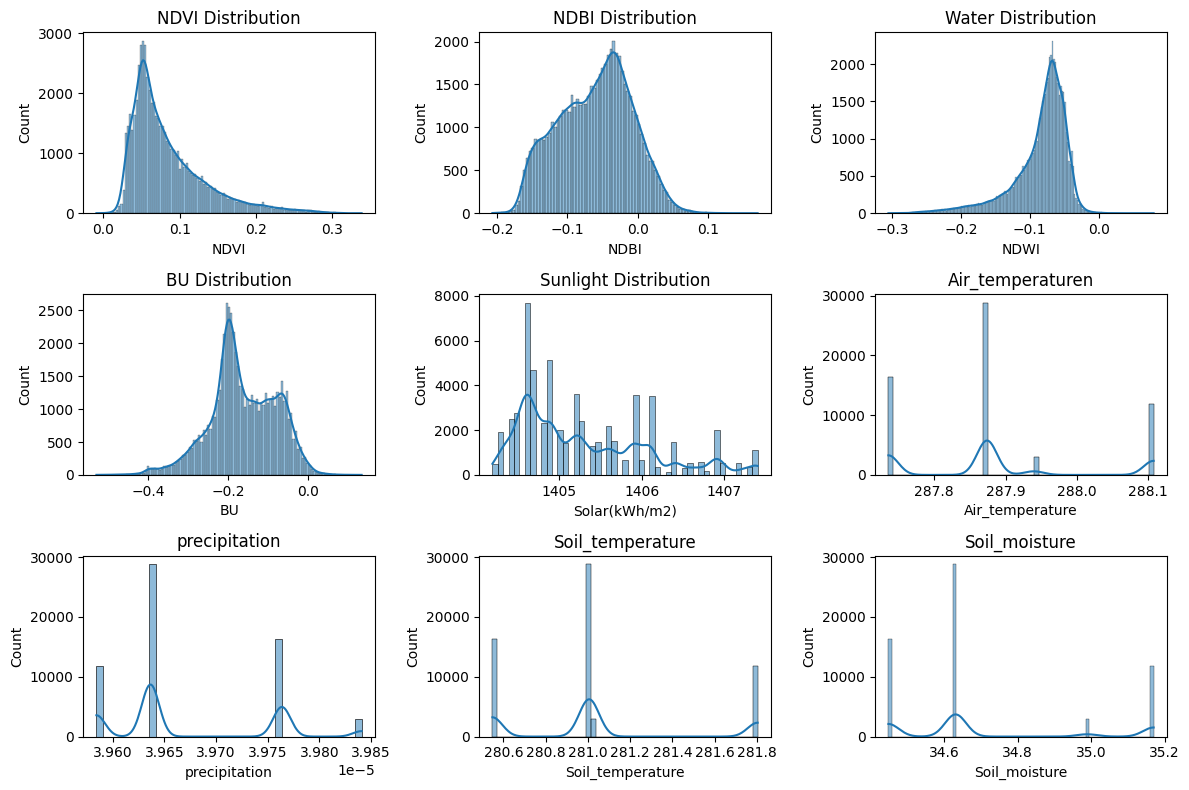

In [61]:
data = [
    (vegsun_climatesoil['NDVI'], 'NDVI Distribution'),
    (vegsun_climatesoil['NDBI'], 'NDBI Distribution'),
    (vegsun_climatesoil['NDWI'], 'Water Distribution'),
    (vegsun_climatesoil['BU'], 'BU Distribution'),
    (vegsun_climatesoil['Solar(kWh/m2)'], 'Sunlight Distribution'),
    (vegsun_climatesoil['Air_temperature'], 'Air_temperature'),
    (vegsun_climatesoil['precipitation'], 'precipitation'),
    (vegsun_climatesoil['Soil_temperature'], 'Soil_temperature'),
    (vegsun_climatesoil['Soil_moisture'], 'Soil_moisture')
   

]

# Creating the figure and subplots
plt.figure(figsize=(12, 8))

# Looping through the data and titles to create subplots
for i, (values, title) in enumerate(data, 1):
    plt.subplot(3, 3, i)
    sns.histplot(values, kde=True)
    plt.title(title)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Correlation matrix:
                      NDVI      NDBI      NDWI        BU  Solar(kWh/m2)  \
NDVI              1.000000 -0.770640 -0.979027 -0.888755      -0.363228   
NDBI             -0.770640  1.000000  0.702505  0.914640       0.301614   
NDWI             -0.979027  0.702505  1.000000  0.848155       0.353431   
BU               -0.888755  0.914640  0.848155  1.000000       0.359140   
Solar(kWh/m2)    -0.363228  0.301614  0.353431  0.359140       1.000000   
Air_temperature   0.039121 -0.002747 -0.032607 -0.009948      -0.186178   
precipitation     0.062438 -0.051393 -0.070116 -0.078688      -0.123344   
Soil_temperature  0.035409 -0.004141 -0.028557 -0.008058      -0.164948   
Soil_moisture     0.071707 -0.024847 -0.066299 -0.042553      -0.269749   

                  Air_temperature  precipitation  Soil_temperature  \
NDVI                     0.039121       0.062438          0.035409   
NDBI                    -0.002747      -0.051393         -0.004141   
NDWI              

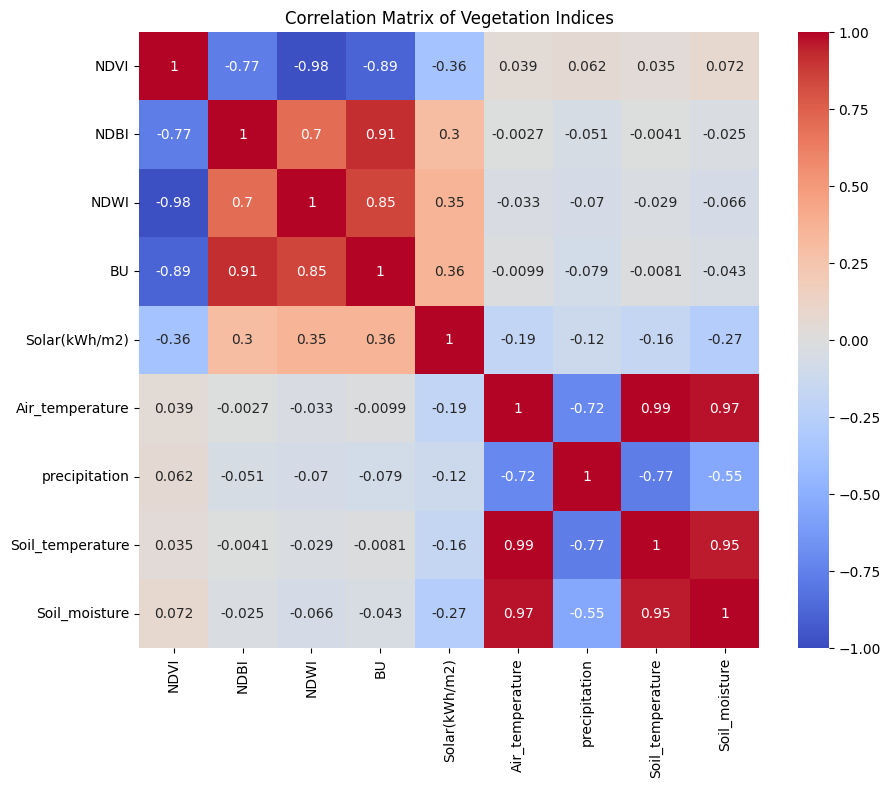

In [64]:
# Correlation matrix
correlation_matrix = vegsun_climatesoil[['NDVI', 'NDBI', 'NDWI', 'BU','Solar(kWh/m2)', 'Air_temperature','precipitation', 'Soil_temperature','Soil_moisture']].corr()
print("\nCorrelation matrix:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Vegetation Indices')
plt.show()

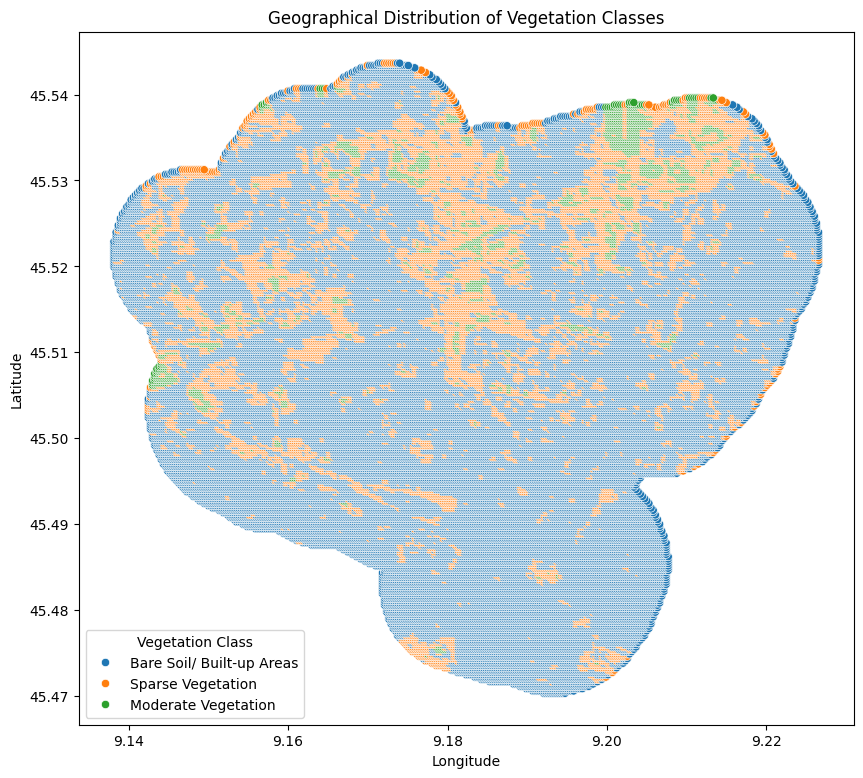

In [65]:
# Scatter plot of the geographical data
plt.figure(figsize=(10, 9))
sns.scatterplot(x='longitude', y='latitude', hue='class', data=vegsun_climatesoil)
plt.title('Geographical Distribution of Vegetation Classes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Vegetation Class')
plt.show()

The distribution of vegetation classes

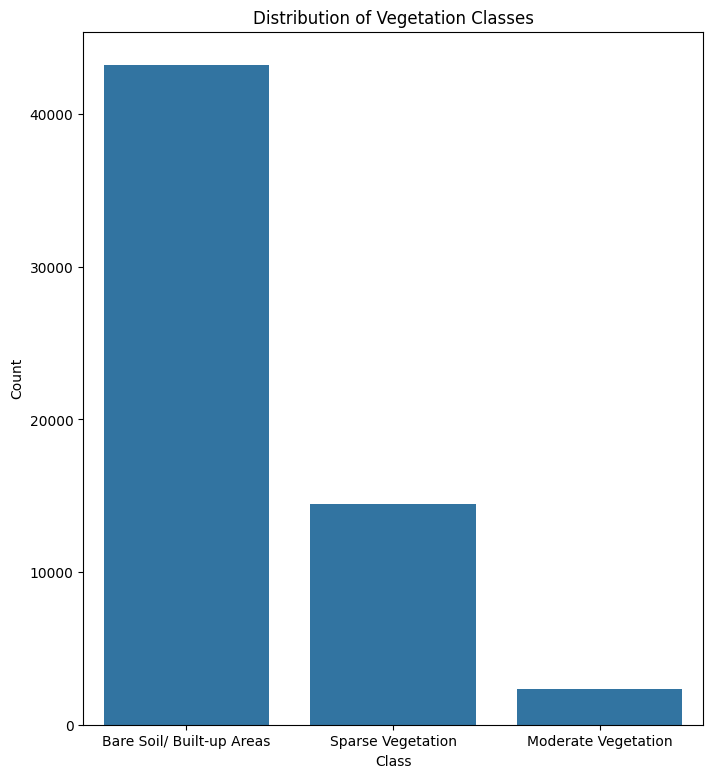

In [66]:
# Ploting the distribution of vegetation classes
plt.figure(figsize=(8, 9))
sns.countplot(x='class', data=vegsun_climatesoil)
plt.title('Distribution of Vegetation Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
